## Reto 1: Pruebas A/B

### 1. Objetivos:
    - Practicar evaluar los resultados de una Prueba A/B
 
---
    
### 2. Desarrollo:

### a) Evaluando una prueba A/B de flujo de ventas

El archivo 'ab_test-sales_pipeline-2' tiene datos muy similares a los que vimos en el último ejemplo. Estamos evaluando dos flujos de ventas distintos: A y B. Cada vez que alguien compró el producto gracias a uno de los dos flujos, se registró como un `1` en la columna `conversion` y un `0` en la columna `no conversion`.

Evalúa la prueba A/B para saber si los resultados obtenidos son estadísticamente significativos. El Reto consiste en los siguientes pasos:

1. Primero cuantifica cuál de los flujos de ventas fue más efectivo y en qué proporción.
2. Después aplica el test de permutación:
    1. Combina los resultados de ambos grupos en un mismo conjunto de datos
    2. Revuelve los datos
    3. Usando muestreo aleatorio sin reposición, construye un nuevo grupo A del mismo tamaño que el original.
    4. El resto de los datos conforman nuestro nuevo grupo B.
    5. Cuantifica la métrica o estadística que calculaste con los grupos originales y guarda el resultado.
    6. Repite los pasos 1-5 `R` veces para obtener una distribución de la estadística de interés.
3. Grafica tus resultados en un histograma y grafica una línea vertical que marque el resultado del experimento.
4. Cuantifica el Valor P y evalúa la significación estadística con un Alfa de 0.05 (5%).
5. Comenta tus hallazgos con tus compañeros y la experta.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/beduExpert/B2-Analisis-de-Datos-con-Python-2020/master/Datasets/ab_test-sales_pipeline-2.csv')

In [11]:
df.head()

,test,conversion,no conversion
0,A,0,1
1,B,0,1
2,A,0,1
3,A,0,1
4,B,0,1


In [12]:
df.sample()

,test,conversion,no conversion
75626,B,1,0


#### Paso 1: Cuantificar la efectividad de los flujos de ventas


In [3]:
total_count = df.groupby('test')[['conversion', 'no conversion']].sum()
total_count['success rate'] = total_count['conversion'] / (total_count['conversion'] + total_count['no conversion'])
print(total_count)

# Calcular la diferencia en proporción
diferencia_en_proporcion = 1 - (total_count.loc['B']['success rate'] / total_count.loc['A']['success rate'])
print(f'El test A fue {diferencia_en_proporcion * 100:.2f}% más efectivo que el test B para generar ventas.')

      conversion  no conversion  success rate
test                                         
A           4163          30576      0.119836
B           4841          36747      0.116404
El test A fue 2.86% más efectivo que el test B para generar ventas.


#### Paso 2: Aplicar el test de permutación

In [5]:
value_counts = df['test'].value_counts()
conv_a = []
no_conv_a = []
conv_b = []
no_conv_b = []

for _ in range(1000):  # R=1000 iteraciones
    # 2c. Construir un nuevo grupo A mediante muestreo aleatorio sin reposición del mismo tamaño que el original
    a = df.sample(value_counts.loc['A'], replace=False)
    # Registrar conversiones y no conversiones para el nuevo grupo A
    conv_a.append(a['conversion'].sum())
    no_conv_a.append(a['no conversion'].sum())
    
    # 2d. El resto de los datos conforman nuestro nuevo grupo B
    b = df.loc[~df.index.isin(a.index)]
    # Registrar conversiones y no conversiones para el nuevo grupo B
    conv_b.append(b['conversion'].sum())
    no_conv_b.append(b['no conversion'].sum())

perm_results = pd.DataFrame({
    'conv_a': conv_a,
    'no_conv_a': no_conv_a,
    'conv_b': conv_b,
    'no_conv_b': no_conv_b
})

# 2e. Calcular la tasa de conversión para cada grupo simulado
perm_results['a_conv_rate'] = perm_results['conv_a'] / (perm_results['conv_a'] + perm_results['no_conv_a'])
perm_results['b_conv_rate'] = perm_results['conv_b'] / (perm_results['conv_b'] + perm_results['no_conv_b'])

# Calcular la diferencia en la tasa de conversión entre los grupos A y B simulados
perm_results['diff'] = 1 - (perm_results['b_conv_rate'] / perm_results['a_conv_rate'])

Valor P: 0.077


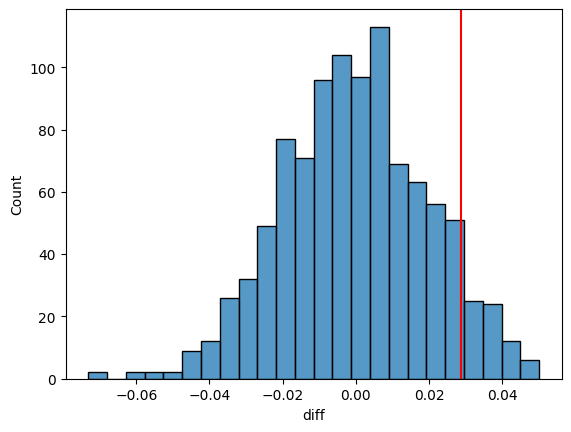

In [6]:
# 3. Graficar los resultados y calcular el Valor P
sns.histplot(perm_results['diff'], kde=False)
plt.axvline(diferencia_en_proporcion, color='r')

# 4. Calcular el Valor P
p_value = (perm_results['diff'] >= diferencia_en_proporcion).sum() / len(perm_results)
print(f'Valor P: {p_value}')


El histograma muestra la la distribución de las diferencias en las tasas de conversión entre los grupos A y B simulados a través de tus 1000 iteraciones del test de permutación. Cada barra del histograma representa el número de veces que se observó una diferencia específica entre las tasas de conversión de los grupos A y B simulados.

- **Hipótesis Nula (H0):** No hay diferencia en la efectividad entre los flujos de ventas A y B. Esto significa que cualquier diferencia observada en las tasas de conversión entre los grupos A y B en nuestra muestra de datos se debe al azar.

- **Hipótesis Alternativa (H1):** Hay una diferencia en la efectividad entre los flujos de ventas A y B. Esto sugiere que la diferencia observada en las tasas de conversión es estadísticamente significativa y no se debe al azar.


Aquí es donde entra en juego el famoso "valor P" de 0.077.

El "nivel de confianza del 95%" es una regla que mucha gente sigue para estar bastante segura de sus decisiones. Si el valor P es menor que 0.05 (lo que significa que hay menos de un 5% de posibilidad de que la diferencia observada sea por casualidad), entonces diríamos que estamos bastante seguros de que un flujo es más efectivo que otro. Pero con un valor P de 0.077, estamos fuera de esa "zona de seguridad"

### ¿Qué Implicaciones Tiene Esto?

El valor P de 0.077 sugiere que esta diferencia podría deberse a la variabilidad aleatoria en lugar de una ventaja real de uno sobre el otro. En términos simples, no estamos suficientemente seguros de que la diferencia observada no sea producto del azar.

##### Entendiendo las Pruebas A/B: ¿Qué estamos intentando descubrir?

Cuando hacemos pruebas A/B, como comparar dos maneras diferentes de vender algo, básicamente estamos tratando de averiguar cuál funciona mejor. Para esto, usamos dos términos importantes:

- **Lo que esperamos que sea cierto si no hay diferencia (Hipótesis Nula):** Imagina que tienes dos recetas de galletas y quieres saber si una es más deliciosa que la otra. Antes de empezar, decides creer que ambas recetas son igual de buenas, hasta que pruebes lo contrario. Esto es lo que llamamos la "Hipótesis Nula".

- **Lo que esperamos descubrir si realmente hay una diferencia (Hipótesis Alternativa):** Ahora, si después de probar descubres que a tus amigos les encantan más las galletas de una receta que de la otra, entonces tienes una buena razón para pensar que una receta podría ser mejor. Esto es lo que llamamos la "Hipótesis Alternativa".


#### Usando pruebas paramétricas para resolver esto: 

## La Prueba Z para Dos Proporciones: Una Explicación Simple

### ¿Qué es la Prueba Z para Dos Proporciones?
La prueba Z para dos proporciones es un método estadístico que nos permite comparar si la diferencia en las tasas de éxito (como las conversiones en ventas entre dos grupos, A y B) es estadísticamente significativa o si podría haber ocurrido por casualidad. Imagina que estás comparando el éxito de dos diferentes estrategias de marketing para ver cuál es más efectiva en convertir prospectos en clientes.

### Supuestos de la Prueba Z
Para que la prueba Z para dos proporciones funcione correctamente y proporcione resultados fiables, debe cumplir con ciertos criterios:

- **Muestreo Aleatorio:** Cada muestra debe ser seleccionada aleatoriamente de la población. Esto asegura que cada individuo tenga la misma oportunidad de ser incluido, similar a cómo podrías elegir a amigos al azar para probar dos tipos diferentes de limonada.

- **Independencia de las Observaciones:** Las respuestas (o resultados) de un individuo no deben influir en las respuestas de otro. Esto es como asegurar que la opinión de un amigo sobre una limonada no cambie la opinión de otro amigo.



In [14]:
from statsmodels.stats.proportion import proportions_ztest

# Contar el número de conversiones en cada grupo
conversiones_A = sum(df[df['test'] == 'A']['conversion'])
conversiones_B = sum(df[df['test'] == 'B']['conversion'])

# Obtener el número total de casos en cada grupo
n_A = len(df[df['test'] == 'A'])
n_B = len(df[df['test'] == 'B'])

# Realizar la prueba Z para dos proporciones
stat, p_valor = proportions_ztest([conversiones_A, conversiones_B], [n_A, n_B])

print(f"P-valor: {p_valor}")

P-valor: 0.14316613936261435


Dado que el p-valor (0.143) es mayor que 0.05, no rechazarías la hipótesis nula. Esto significa que, basándose en los datos de tu estudio, no hay evidencia suficiente para concluir que existe una diferencia estadísticamente significativa entre los grupos comparados